In [305]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from numpy import genfromtxt
from scipy import stats

In [306]:
# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1]
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [307]:
def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', header=None)
    return df

def merge_column(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[1]/2):
        new_df[i] = df[i] * df[i+1]
    return new_df

# https://stackoverflow.com/a/42523230
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        del df[each]
        df = pd.concat([df, dummies], axis=1)
    return df

In [308]:
df = read_data('poker-hand-training-true.data')
df_test = read_data('poker-hand-testing.data')

df = one_hot(df, df.iloc[:,:-1].columns)
df_test = one_hot(df_test, df_test.iloc[:,:-1].columns)
print(df.tail())
print(df_test.tail())
# df[10].value_counts().sort_index().plot('bar')

       10  0_1  0_2  0_3  0_4  1_1  1_2  1_3  1_4  1_5  ...   9_4  9_5  9_6  \
25005   0    0    0    1    0    0    0    0    0    0  ...     1    0    0   
25006   1    0    0    0    1    1    0    0    0    0  ...     0    0    0   
25007   1    0    1    0    0    1    0    0    0    0  ...     0    0    0   
25008   1    0    1    0    0    0    0    0    0    0  ...     0    0    0   
25009   1    1    0    0    0    0    0    0    0    0  ...     0    0    0   

       9_7  9_8  9_9  9_10  9_11  9_12  9_13  
25005    0    0    0     0     0     0     0  
25006    0    0    0     1     0     0     0  
25007    0    0    0     0     0     0     1  
25008    0    0    1     0     0     0     0  
25009    1    0    0     0     0     0     0  

[5 rows x 86 columns]
        10  0_1  0_2  0_3  0_4  1_1  1_2  1_3  1_4  1_5  ...   9_4  9_5  9_6  \
999995   1    0    0    1    0    1    0    0    0    0  ...     0    0    1   
999996   1    0    0    1    0    0    0    1    0    0  ...

In [309]:
features = df.iloc[:, 1:].values
labels = df.iloc[:, :1].values
print(stats.describe(features).variance)
print(features.shape, labels.shape)

features_test = df_test.iloc[:, :-1].values
labels_test = df_test.iloc[:, -1:].values

[ 0.18544144  0.18841386  0.18745751  0.18869141  0.07297093  0.07158867
  0.06959014  0.07084475  0.06992965  0.06884207  0.07226361  0.07182504
  0.07246585  0.06942026  0.07108162  0.07155489  0.07070933  0.18863199
  0.18733744  0.1855836   0.18845355  0.07307185  0.07091245  0.07060773
  0.07037055  0.06833114  0.072095    0.07060773  0.07013321  0.06942026
  0.07094629  0.07125072  0.0715211   0.07381113  0.18705685  0.18661465
  0.18550239  0.19079198  0.07003145  0.07053998  0.07239845  0.07138594
  0.0708786   0.06965806  0.07111545  0.07060773  0.06856966  0.07357607
  0.0706416   0.07313913  0.07053998  0.18783694  0.1874175   0.18873101
  0.18602939  0.07300457  0.07313913  0.07354248  0.07026885  0.0696241
  0.0706416   0.07165622  0.06901222  0.07175752  0.07101396  0.07199379
  0.06809246  0.06931829  0.18861217  0.18588772  0.18873101  0.18677563
  0.07256692  0.07212873  0.07067547  0.07175752  0.07233104  0.06999752
  0.06792188  0.07337447  0.07125072  0.07182504  0.

In [310]:
train_x = features
train_y = labels
test_x = features_test
test_y = labels_test

feature_count = train_x.shape[1]
label_count = train_y.shape[1]
print(feature_count, label_count)

85 1


In [311]:
training_epochs = 2000
learning_rate = 0.1
cost_history = np.empty(shape=[1],dtype=float)
nb_classes = 10

# x는 float32 로 할 필요가 있나? normalized 되었기때문에 float32 써야함 or dropout에서 float를 씀
X = tf.placeholder(tf.float32,[None,feature_count])
Y = tf.placeholder(tf.int32,[None,label_count])
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

one_hot Tensor("one_hot_20:0", shape=(?, 1, 10), dtype=float32)
reshape Tensor("Reshape_71:0", shape=(?, 10), dtype=float32)


In [312]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.1)), tf.Variable(tf.random_normal([shape[1]]))

def make_hidden_layer(previous_h, weight, bias, p_keep_hidden):
    h = tf.nn.relu(tf.matmul(previous_h, weight) + bias)
    h = tf.nn.dropout(h, p_keep_hidden)
    return h

def model(X, p_keep_input, p_keep_hidden): # this network is the same as the previous one except with an extra hidden layer + dropout
    s_1 = feature_count + 2
    s_2 = feature_count + 2
    s_3 = feature_count
    s_4 = feature_count
    
    w_h, b = init_weights([feature_count, s_1])
    w_h2, b2 = init_weights([s_1, s_2])
    w_h3, b3 = init_weights([s_2, s_3])
    w_h4, b4 = init_weights([s_3, s_4])
    w_o, b_o = init_weights([s_4, nb_classes])
    
    X = tf.nn.dropout(X, p_keep_input)
    h = make_hidden_layer(X, w_h, b, p_keep_hidden)
    h2 = make_hidden_layer(h, w_h2, b2, p_keep_hidden)
    h3 = make_hidden_layer(h2, w_h3, b3, p_keep_hidden)
    h4 = make_hidden_layer(h3, w_h4, b4, p_keep_hidden)
    
    return tf.matmul(h4, w_o) + b_o

In [313]:
p_keep_input = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

h0 = model(X, p_keep_input, p_keep_hidden)

In [314]:
# Cross entropy cost/loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h0, labels=Y_one_hot))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [315]:
prediction = tf.argmax(h0, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [316]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(X.shape, Y.shape)
training_dropout_i = 0.8
training_dropout_h = 0.7
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        cost_history = np.append(cost_history, acc)
        if step % 1000 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    pre = tf.argmax(h0, 1)
    test_yy = np.transpose(test_y.ravel())
    print(test_yy.shape)
    correct_prediction = tf.equal(pre, test_yy)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test Accuracy:', sess.run(accuracy, feed_dict={X: test_x, 
                                                         p_keep_input: 1.0,
                                                         p_keep_hidden: 1.0}))

(25010, 85) (25010, 1)
(1000000, 85) (1000000, 1)
(?, 85) (?, 1)
Step:     0	Loss: 54.624	Acc: 49.00%
Step:  1000	Loss: 0.986	Acc: 49.95%
Step:  2000	Loss: 0.985	Acc: 49.95%
(1000000,)
Test Accuracy: 0.923413


(2002,)


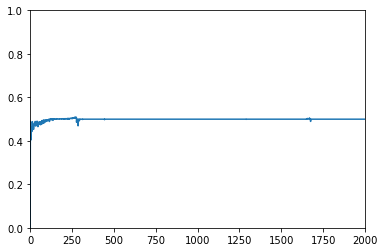

In [317]:
print(cost_history.shape)
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,1])
plt.show()

In [318]:
sess.close()